In [62]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load datasets
train_data_path = '/content/train_final_monthly (1).csv'
test_data_path = '/content/test_final_monthly (1).csv'

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

# Convert 'MonthYear' to datetime and extract year and month
train_df['MonthYear'] = pd.to_datetime(train_df['MonthYear'])
test_df['MonthYear'] = pd.to_datetime(test_df['MonthYear'])

train_df['Year'] = train_df['MonthYear'].dt.year
train_df['Month'] = train_df['MonthYear'].dt.month
test_df['Year'] = test_df['MonthYear'].dt.year
test_df['Month'] = test_df['MonthYear'].dt.month

# Add lagged feature and fill missing values
train_df['Lag1'] = train_df['Minimum'].shift(1)
test_df['Lag1'] = test_df['Minimum'].shift(1).fillna(method='bfill')

# Add moving average feature and fill missing values
train_df['MovingAvg3'] = train_df['Minimum'].rolling(window=3).mean()
test_df['MovingAvg3'] = test_df['Minimum'].rolling(window=3).mean().fillna(method='bfill')

# Drop remaining NaN values (if any)
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Convert 'Commodity' to numeric encoding
train_df['Commodity'] = train_df['Commodity'].astype('category').cat.codes
test_df['Commodity'] = test_df['Commodity'].astype('category').cat.codes

# Split features and target
X_train = train_df.drop(columns=['Minimum', 'MonthYear']).values
y_train = train_df['Minimum'].values

X_test = test_df.drop(columns=['Minimum', 'MonthYear']).values
y_test = test_df['Minimum'].values

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Reshape input data for GRU (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the GRU model (more complex with dropout)
model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)


Epoch 1/150


<ipython-input-62-4c11d222ce9c>:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df['Lag1'] = test_df['Minimum'].shift(1).fillna(method='bfill')
<ipython-input-62-4c11d222ce9c>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df['MovingAvg3'] = test_df['Minimum'].rolling(window=3).mean().fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - loss: 0.1986 - mae: 0.3824 - val_loss: 0.1552 - val_mae: 0.3422
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1296 - mae: 0.2894 - val_loss: 0.0666 - val_mae: 0.1886
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0505 - mae: 0.1704 - val_loss: 0.0297 - val_mae: 0.1530
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0478 - mae: 0.1833 - val_loss: 0.0503 - val_mae: 0.1984
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0516 - mae: 0.1791 - val_loss: 0.0448 - val_mae: 0.1844
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0437 - mae: 0.1704 - val_loss: 0.0266 - val_mae: 0.1496
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0299 - mae: 0.1355 - val_loss: 0.0233 - val_mae: 0.1267
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0352 - mae: 0.1563 - val_loss: 0.0243 - val_mae: 0.1248
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0283 - mae: 0.1396 - va

In [63]:
# Evaluate predictions
actual_values = scaler_y.inverse_transform(y_test.reshape(-1, 1))
predicted_values = predictions

# Calculate metrics
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 9.83272964075992
Root Mean Square Error (RMSE): 11.097029578371382
Mean Absolute Percentage Error (MAPE): 27.47%


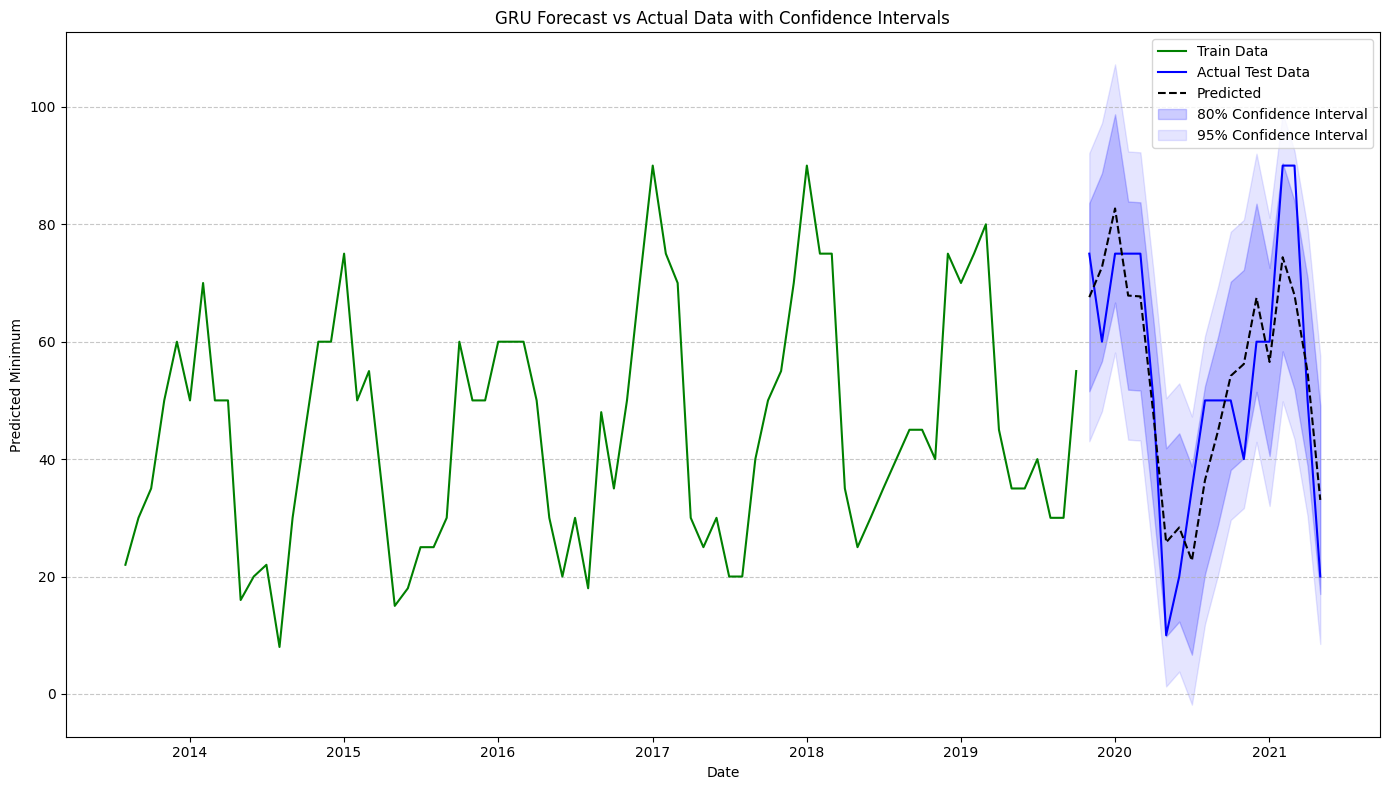

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Create confidence intervals
# Assume standard deviation of residuals as the uncertainty
std_residuals = np.std(residuals)
upper_80 = predicted_values.flatten() + 1.28 * std_residuals  # 80% confidence interval
lower_80 = predicted_values.flatten() - 1.28 * std_residuals
upper_95 = predicted_values.flatten() + 1.96 * std_residuals  # 95% confidence interval
lower_95 = predicted_values.flatten() - 1.96 * std_residuals

# Create a date range for visualization
train_dates = train_df['MonthYear']
test_dates = test_df['MonthYear']

# Convert predictions to a full timeline (combine train and test predictions)
all_dates = np.concatenate([train_dates, test_dates])

# Plot the graph
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(train_dates, scaler_y.inverse_transform(y_train.reshape(-1, 1)), label='Train Data', color='green')

# Plot actual test data
plt.plot(test_dates, scaler_y.inverse_transform(y_test.reshape(-1, 1)), label='Actual Test Data', color='blue')

# Plot predictions
plt.plot(test_dates, predicted_values, label='Predicted', color='black', linestyle='--')

# Plot confidence intervals
plt.fill_between(test_dates, lower_80, upper_80, color='blue', alpha=0.2, label='80% Confidence Interval')
plt.fill_between(test_dates, lower_95, upper_95, color='blue', alpha=0.1, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title('GRU Forecast vs Actual Data with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Predicted Minimum')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
